In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from eumap.misc import find_files, ttprint
from eumap.raster import read_rasters, save_rasters
from eumap.mapper import SpaceOverlay
import geopandas as gpd
from pathlib import Path
import rasterio
import pyproj
from shapely.geometry import Point
from eumap.mapper import LandMapper
from scipy.special import expit, logit

import warnings

import matplotlib
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from quantile_forest import RandomForestQuantileRegressor
import joblib
import pickle
from benchmark_pipeline import read_features

### refit model on spatial aggregated data
- fit
- validate

In [2]:
# load model
nuts_level = 1

file_rf = '/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/model_rf.oc_log1p.ccc.joblib'
rf = joblib.load(file_rf)
rf.n_jobs = 90
params = rf.get_params()
qrf = RandomForestQuantileRegressor(**params)

# covariates
covs = read_features('/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/feature_optimal.txt')
covs_nuts = [icov+'_mean' for icov in covs]
prop = 'oc_mean'
tgt = 'oc_log1p'

gdf_nuts = gpd.read_file(f'/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/nuts{nuts_level}_aggregated.gpkg')
gdf_nuts = gdf_nuts.loc[gdf_nuts['hzn_dep']==10]
gdf_nuts.loc[:,tgt] = np.log1p(gdf_nuts[prop])

# select 10% validation dataset
group_col = f'nuts{nuts_level}_id'
gkf = GroupKFold(n_splits=10)
for train_idx, val_idx in gkf.split(gdf_nuts, groups=gdf_nuts[group_col]):
    break
train = gdf_nuts.iloc[train_idx].copy()
test = gdf_nuts.iloc[val_idx].copy()

print(f'training size: {len(train)}')
print(f'test size: {len(test)}')

training size: 392
test size: 45


/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/code/benchmark_pipeline.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar


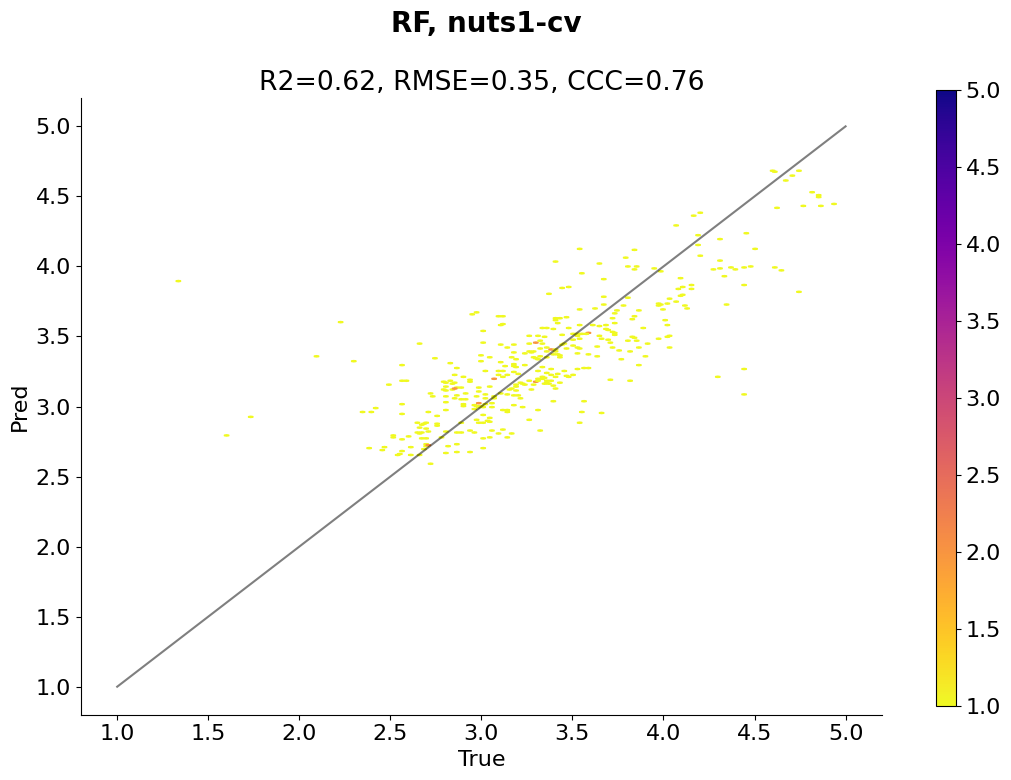

In [3]:
cv = GroupKFold(n_splits=5)
spatial_cv_column = group_col

import math
show_low = math.floor(train[tgt].min())
show_high = math.ceil(train[tgt].max())

y_pred = cross_val_predict(rf, train[covs_nuts], train[tgt], cv=cv, groups=train[spatial_cv_column], n_jobs=-1)
y_true = train[tgt]

from benchmark_pipeline import accuracy_plot
r2_cv, rmse_cv, ccc_cv = accuracy_plot(y_true, y_pred, f'RF, nuts{nuts_level}-cv', 
                                       output_folder='/mnt/primus/xuemeng_tmp_harbour/soc/result_paper', 
                                       show_range = [show_low, show_high], vmax=5) # visuliazation

/mnt/primus/xuemeng_tmp_harbour/soc/SOC-EU/code/benchmark_pipeline.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar


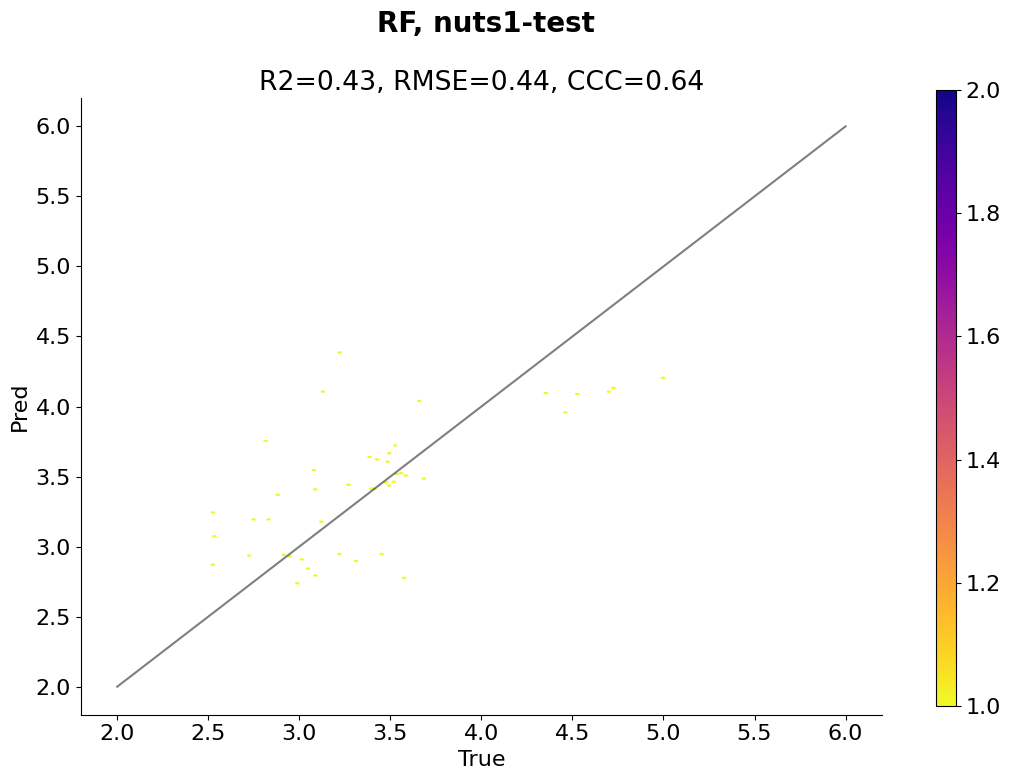

In [4]:
show_low = math.floor(test[tgt].min())
show_high = math.ceil(test[tgt].max())
rf.n_jobs = 90
rf.fit(train[covs_nuts], train[tgt])
y_pred = rf.predict(test[covs_nuts])
y_true = test[tgt]
r2_test, rmse_test, ccc_test = accuracy_plot(y_true, y_pred, f'RF, nuts{nuts_level}-test', 
                                          output_folder='/mnt/primus/xuemeng_tmp_harbour/soc/result_paper',
                                          show_range = [show_low, show_high], vmax=2) # visuliazation

### quantile rf
- to ease the check of uncertainty, we use the original scale here

In [5]:
def calc_picp(lower_bounds, upper_bounds, true_values):
    within_bounds = np.sum((true_values >= lower_bounds) & (true_values <= upper_bounds))
    picp = within_bounds / len(true_values)
    return picp

def calc_qcp(predictions, true_values, quantile):
    return np.mean(true_values <= predictions)

def quantile_cross_val_predict(estimator, X, y, cv, quantiles, groups=None):
    """ Custom cross-validation to handle quantile predictions with group support. """
    predictions = {q: [] for q in quantiles}
    if groups is None:
        cv_split = cv.split(X)
    else:
        cv_split = cv.split(X, y, groups)
    
    for train_idx, test_idx in cv_split:
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        
        # Fit the model on the training data
        estimator.fit(X_train, y_train)
        
        # Predict each quantile and store results
        for q in quantiles:
            pred = estimator.predict(X_test, quantiles=q)
            predictions[q].extend(pred)
    
    return predictions

/home/opengeohub/.local/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


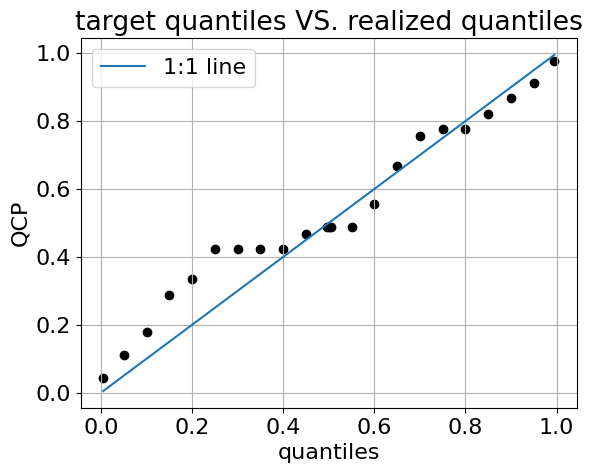

In [6]:
import numpy as np
quantiles = [0.005, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.495, 0.5 , 0.505, 0.55,
             0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.995]

qrf.fit(train[covs_nuts], train[prop])
y_pred_test = qrf.predict(test[covs_nuts], quantiles=quantiles)

qcp = []
for ii in range(len(quantiles)):
    qcp.append(calc_qcp(y_pred_test[:,ii], test[prop], quantiles[ii]))

pi = []
picp = []
piw = []
for ii in range(11):
    jj = len(quantiles)-1-ii
    pi.append(round(1-quantiles[ii]*2,2))
    picp.append(calc_picp(y_pred_test[:,ii], y_pred_test[:,jj], test[prop]))
    piw.append(np.mean(y_pred_test[:,jj]-y_pred_test[:,ii]))

fig, ax = plt.subplots()
ax.plot(quantiles, quantiles, label='1:1 line')
ax.scatter(quantiles, qcp, color='black')
ax.set_xlabel('quantiles')
ax.set_ylabel('QCP')
ax.set_title('target quantiles VS. realized quantiles')
ax.grid(True)
plt.legend()
plt.show()

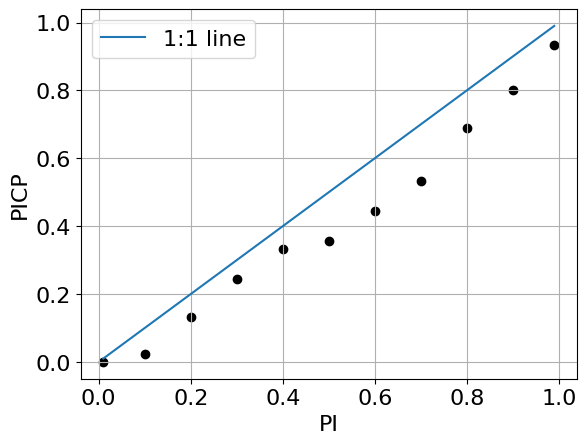

In [7]:
fig, ax = plt.subplots()
ax.plot(pi, pi, label='1:1 line')
ax.scatter(pi, picp, color='black')
ax.set_xlabel('PI')
ax.set_ylabel('PICP')
ax.grid(True)
plt.legend()
plt.show()

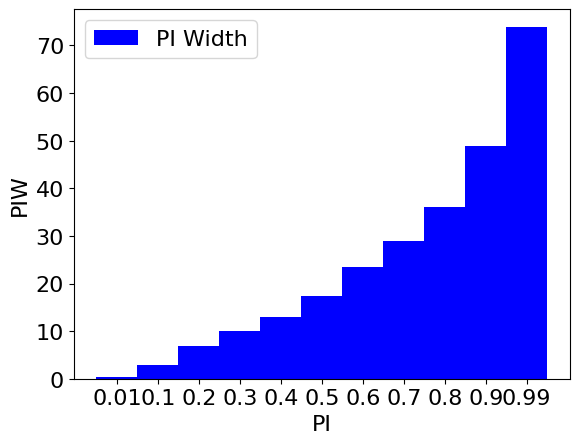

In [8]:
x_positions = list(range(len(piw), 0, -1))

fig, ax = plt.subplots()
ax.bar(x_positions, piw, width=1, color='blue', label='PI Width')
ax.set_xticks(x_positions)  # Set x-ticks at the positions listed in `pi`
ax.set_xticklabels([f'{p}' for p in pi])
ax.set_xlabel('PI')
ax.set_ylabel('PIW')
# ax.grid(True)
plt.legend()
plt.show()

### check temporal soc change

In [9]:
test['oc_quantile.95'] = y_pred_test[:,-2]
test['oc_quantile.05'] = y_pred_test[:,1]
test['oc_pred'] = np.expm1(y_pred)

data = test[[f'nuts{nuts_level}_id',f'nuts{nuts_level}_name','time','oc_mean','oc_std','oc_count','oc_pred','oc_quantile.95','oc_quantile.05']]

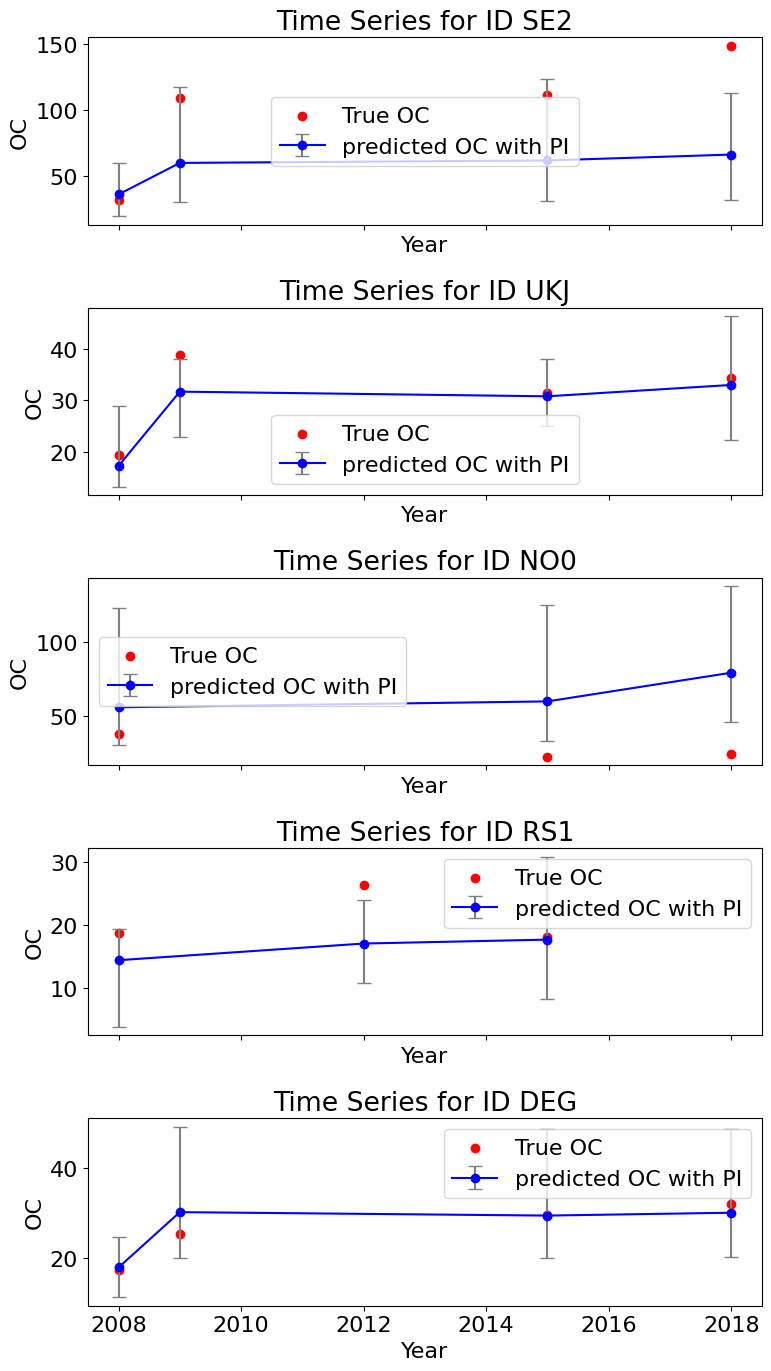

In [10]:
sample_ids = np.random.choice(data[f'nuts{nuts_level}_id'].unique(), size=5, replace=False)
fig, axes = plt.subplots(nrows=len(sample_ids), ncols=1, figsize=(8, 14), sharex=True)

# Initialize the plot index
i = 0

for sample_id in sample_ids:
    sample_data = data[data[f'nuts{nuts_level}_id'] == sample_id].sort_values('time')
    if len(sample_data) < 2:
        continue

    # Check if any oc_pred values fall outside the 5th and 95th quantiles
    if any((sample_data['oc_pred'] < sample_data['oc_quantile.05']) | (sample_data['oc_pred'] > sample_data['oc_quantile.95'])):
        continue

    # Calculate yerr ensuring no negative values
    yerr_lower = np.abs(sample_data['oc_pred'] - sample_data['oc_quantile.05'])
    yerr_upper = np.abs(sample_data['oc_quantile.95'] - sample_data['oc_pred'])

    # Plot the data
    axes[i].errorbar(sample_data['time'], sample_data['oc_pred'], 
                     yerr=[yerr_lower, yerr_upper], 
                     fmt='o', linestyle='-', color='blue', ecolor='gray', capsize=5, label='predicted OC with PI')
    axes[i].scatter(sample_data['time'], sample_data['oc_mean'], color='red', label='True OC')
    axes[i].set_title(f'Time Series for ID {sample_id}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('OC')
    axes[i].legend()
    
    # Increment the plot index after successfully plotting
    i += 1

# Remove any unused subplots
for j in range(i, len(sample_ids)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
def check_non_overlapping_intervals(data):
    data = data.sort_values('time')
    # check if the true value fall within the PI
    a = data.loc[(data['oc_mean'] < data['oc_quantile.05']) | (data['oc_mean'] > data['oc_quantile.95'])]
    if len(a) > 0:
        return False
    # check if the predicted value fall within the PI
    a = data.loc[(data['oc_pred'] < data['oc_quantile.05']) | (data['oc_pred'] > data['oc_quantile.95'])]
    if len(a) > 0:
        return False
    
    # check if there are model detectable change
    for i in range(len(data) - 1):
        # if (data.iloc[i]['oc_quantile.95'] < data.iloc[i + 1]['oc_quantile.05'] or
        #     data.iloc[i]['oc_quantile.05'] > data.iloc[i + 1]['oc_quantile.95']):
        #     return True
        if (data.iloc[i+1]['oc_quantile.05'] > data.iloc[i]['oc_pred'] and
            data.iloc[i+1]['oc_pred'] > data.iloc[i]['oc_quantile.95']):
            return True
        if (data.iloc[i+1]['oc_quantile.95'] < data.iloc[i]['oc_quantile.05'] and
            data.iloc[i+1]['oc_pred'] < data.iloc[i]['oc_pred']):
            return True
    return False

non_overlapping_ids = []
ts_total = 0
for id, group in test[test['hzn_dep'] == 10].groupby(f'nuts{nuts_level}_id'):
    if len(group['time'].unique()) > 1:
        ts_total = ts_total+1
        if check_non_overlapping_intervals(group):
            non_overlapping_ids.append(id)
        
print(f'{ts_total} time series in total in validation dataset, {len(non_overlapping_ids)} from which have detectable change')

8 time series in total in validation dataset, 1 from which have detectable change


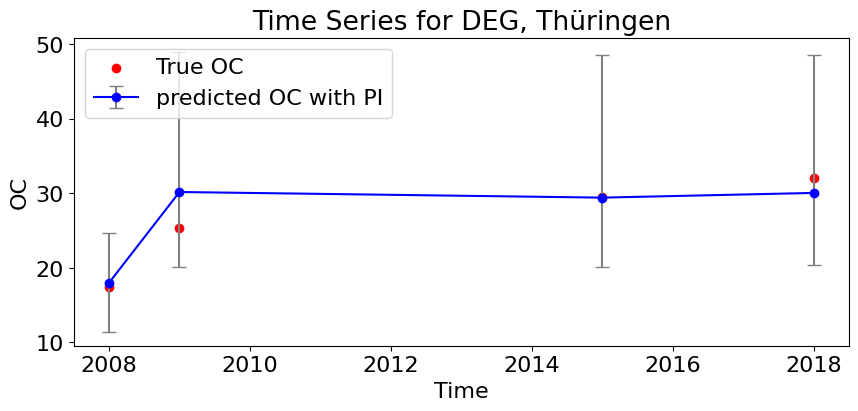

In [12]:
import matplotlib.pyplot as plt

for sample_id in non_overlapping_ids:
    sample_data = test[test[f'nuts{nuts_level}_id'] == sample_id].sort_values('time')
    name = sample_data[f'nuts{nuts_level}_name'].iloc[0]
    plt.figure(figsize=(10, 4))
    
    # Calculate the lower and upper errors
    lower_error = sample_data['oc_pred'] - sample_data['oc_quantile.05']
    upper_error = sample_data['oc_quantile.95'] - sample_data['oc_pred']
    
    # Use plt.errorbar to add error bars
    plt.errorbar(sample_data['time'], sample_data['oc_pred'], 
                 yerr=[lower_error, upper_error], fmt='o', linestyle='-', 
                 color='blue', ecolor='gray', capsize=5, label='predicted OC with PI')
    plt.scatter(sample_data['time'], sample_data['oc_mean'],color='red', label='True OC')
    plt.title(f'Time Series for {sample_id}, {name}')
    plt.xlabel('Time')
    plt.ylabel('OC')
    plt.legend()
    plt.show()

In [13]:
len(non_overlapping_ids)

1

### Spatial aggregation

In [14]:
# prop = 'oc'
# tgt = f'{prop}_log1p'
# folder = f'/mnt/primus/xuemeng_tmp_harbour/soc/results/{prop}'
# filt = 5

# # load all the data
# df = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/data/002_data_whole.csv',low_memory=False)
# df = df.loc[df[prop].notna()]
# df = df.loc[df[f'{prop}_qa']>filt]
    
# # covariates
# covs_a = pd.read_csv('/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/feature_optimal.txt').values.tolist()
# covs = [item for sublist in covs_a for item in sublist]

# dff = df.dropna(subset=covs,how='any')

# # Create GeoDataFrame from dff with geometry
# geometry = [Point(xy) for xy in zip(dff['lon'], dff['lat'])]
# gdff = gpd.GeoDataFrame(dff, geometry=geometry, crs="EPSG:4326")

# # Read in NUTS shapefile and select relevant columns
# nuts = gpd.read_file('/mnt/inca/tillage_index/data/EUROSTATS/nuts2/NUTS_RG_20M_2021_3035.shp')
# nuts = nuts[['NUTS_ID', 'NUTS_NAME', 'geometry', 'LEVL_CODE']]
# nuts = nuts.to_crs("EPSG:4326")


# # Assign NUTS ID at each NUTS level
# for inuts in nuts['LEVL_CODE'].unique():
#     nuts_t = nuts[nuts['LEVL_CODE'] == inuts].copy()
#     nuts_t[f'geometry_nuts{inuts}'] = nuts_t['geometry']
    
#     gdff = gpd.sjoin(gdff, nuts_t, op='within')
#     gdff = gdff.drop(columns=['index_right', 'LEVL_CODE'])
#     gdff = gdff.rename(columns={'NUTS_ID': f'nuts{inuts}_id', 'NUTS_NAME': f'nuts{inuts}_name'})

# # a = gdff.sample(frac=0.01)
# # a.to_csv('/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/test_gpt.csv')

# drop_cols = ['id', 'lat', 'lon', 'ref', 'nuts0', 'ph_h2o', 'ph_cacl2',
#        'bulk_density', 'clay', 'silt', 'sand', 'caco3', 'N', 'K', 'P', 'CEC',
#        'EC', 'oc_qa', 'N_qa', 'caco3_qa', 'bulk_density_qa', 'clay_qa',
#        'silt_qa', 'sand_qa', 'ph_h2o_qa', 'ph_cacl2_qa', 'P_qa', 'K_qa',
#        'EC_qa', 'CEC_qa']

# gdff = gdff.drop(columns=drop_cols)

# # spatial aggregate
# for inuts in [0, 1, 2, 3]:

#     # Aggregate data
#     nuts_id_col = f'nuts{inuts}_id'
#     nuts_name_col = f'nuts{inuts}_name'
#     nuts_geom_col = f'geometry_nuts{inuts}'
    
#     # Prepare the aggregation dictionary
#     agg_dict = {
#         'oc': ['mean', 'std', 'count']
#     }
#     for cov in covs:
#         agg_dict[cov] = ['mean', 'std']
    
#     aggregated = gdff.groupby([nuts_id_col, nuts_name_col, 'hzn_dep', 'time']).agg(agg_dict).reset_index()
#     aggregated.columns = ['_'.join(col).rstrip('_') for col in aggregated.columns.values]

#     # Ensure the geometry column is properly handled as a GeoSeries
#     nuts_geom = gdff[[nuts_id_col, nuts_name_col, nuts_geom_col]].drop_duplicates().reset_index(drop=True)
#     nuts_geom[nuts_geom_col] = gpd.GeoSeries(nuts_geom[nuts_geom_col])
    
#     # Merge with the geometries
#     result = pd.merge(aggregated, nuts_geom, on=[nuts_id_col, nuts_name_col])
    
#     # Convert to GeoDataFrame
#     gdf = gpd.GeoDataFrame(result, geometry=nuts_geom_col)
    
#     # Save to file
#     output_path = f'/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/nuts{inuts}_aggregated.gpkg'
#     gdf.to_file(output_path, driver="GPKG")
    
#     # Display intermediate product
#     print(f"Intermediate product for NUTS level {inuts} saved to {output_path}")
